In [1]:
import harmonypy as hm
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import umap
import sklearn.neighbors
import sklearn.metrics
import itertools
import glob

%matplotlib inline

In [2]:
wkdir = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/9_Harmony'
os.chdir(wkdir)

-----

## 0. Pre Process Inputs

In [4]:
###----- Normalized to 10e4 per cell --> Log natural base (x+1)
exp391_expr_scaled_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all_norm_counts_named_log_scaled.csv'
exp334_expr_scaled_file = '/media/pipkin/Yolanda/Exp334CD25KOSc/0_codes/1_2_PAGA_allgenes/all_norm_counts_named_log_scaled.csv'
exp392_expr_scaled_file = '/media/pipkin/Yolanda/Exp392_shCRF_SC/1_1_SCANPY_PAGA/all_norm_counts_named_log_scaled.csv'

exp391_expr_scaled_tb = pd.read_csv(exp391_expr_scaled_file)
exp334_expr_scaled_tb = pd.read_csv(exp334_expr_scaled_file)
exp392_expr_scaled_tb = pd.read_csv(exp392_expr_scaled_file)

# Unify column names
exp391_expr_scaled_tb.columns = ["cell_id"] +  list(exp391_expr_scaled_tb.columns)[1:]
exp334_expr_scaled_tb.columns = ["cell_id"] +  list(exp334_expr_scaled_tb.columns)[1:]
exp392_expr_scaled_tb.columns = ["cell_id"] +  list(exp392_expr_scaled_tb.columns)[1:]

In [5]:
###----- Read obs files, select highly variable genes & used cells
# Outlier filtered cells 
exp391_obs = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all--numSlt-rmWTNAV/0_PAGA/obs_qcFlt-outFlt.csv'
exp334_obs = '/media/pipkin/Yolanda/Exp334CD25KOSc/0_codes/1_2_PAGA/obs.csv'
exp392_obs = '/media/pipkin/Yolanda/Exp392_shCRF_SC/1_1_SCANPY_PAGA/shCRF-numSlt_fltType/0_PAGA/obs_qcFlt-outFlt.csv'

exp391_obs_tb = pd.read_csv(exp391_obs)
exp334_obs_tb = pd.read_csv(exp334_obs)
exp392_obs_tb = pd.read_csv(exp392_obs)

exp391_obs_tb.columns = ['cell_id'] + list(exp391_obs_tb.columns)[1:]
exp334_obs_tb.columns = ['cell_id'] + list(exp334_obs_tb.columns)[1:]
exp392_obs_tb.columns = ['cell_id'] + list(exp392_obs_tb.columns)[1:]

#Analyzed cells
exp391_obs_use = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all--numSlt-rmWTNAV/0_PAGA/all--numSlt-rmWTNAV/obs.csv'
exp334_obs_use = '/media/pipkin/Yolanda/Exp334CD25KOSc/0_codes/1_2_PAGA/obs.csv'
exp392_obs_use = '/media/pipkin/Yolanda/Exp392_shCRF_SC/1_1_SCANPY_PAGA/shCRF-numSlt_fltType/0_PAGA/shCRF-numSlt_fltType/obs.csv'

exp391_obs_use_tb = pd.read_csv(exp391_obs_use)
exp334_obs_use_tb = pd.read_csv(exp334_obs_use)
exp392_obs_use_tb = pd.read_csv(exp392_obs_use)

exp391_obs_use_tb.columns = ['cell_id'] + list(exp391_obs_use_tb.columns)[1:]
exp334_obs_use_tb.columns = ['cell_id'] + list(exp334_obs_use_tb.columns)[1:]
exp392_obs_use_tb.columns = ['cell_id'] + list(exp392_obs_use_tb.columns)[1:]

exp391_obs_use_tb = exp391_obs_use_tb[['cell_id','cell_type','louvain', 'dpt_pseudotime']]
exp334_obs_use_tb = exp334_obs_use_tb[['cell_id','cell_type','louvain', 'dpt_pseudotime']]
exp392_obs_use_tb = exp392_obs_use_tb[['cell_id','cell_type','louvain', 'dpt_pseudotime']]

exp391_obs_use_tb['dataset'] = ['Exp391' for x in exp391_obs_use_tb['cell_id']]
exp334_obs_use_tb['dataset'] = ['Exp334' for x in exp334_obs_use_tb['cell_id']]
exp392_obs_use_tb['dataset'] = ['Exp392' for x in exp392_obs_use_tb['cell_id']]

all_usedCells_meta = pd.concat([exp391_obs_use_tb, exp334_obs_use_tb, exp392_obs_use_tb])

In [6]:
###----- Select cells & Genes for analysis
# Find all highly variable genes that are present in all datasets
use_cols = list(exp391_expr_scaled_tb.columns)[1:]
use_cols = list(set(use_cols) & set(list(exp334_expr_scaled_tb.columns)[1:]))
use_cols = list(set(use_cols) & set(list(exp392_expr_scaled_tb.columns)[1:]))
use_cols = ['cell_id'] + use_cols

exp391_expr_scaled_tb = exp391_expr_scaled_tb.loc[exp391_expr_scaled_tb['cell_id'].
                                                  isin(list(exp391_obs_tb['cell_id']))]
exp334_expr_scaled_tb = exp334_expr_scaled_tb.loc[exp334_expr_scaled_tb['cell_id'].
                                                  isin(list(exp334_obs_tb['cell_id']))]
exp392_expr_scaled_tb = exp392_expr_scaled_tb.loc[exp392_expr_scaled_tb['cell_id'].
                                                  isin(list(exp392_obs_tb['cell_id']))]

exp391_expr_scaled_tb = exp391_expr_scaled_tb[use_cols]
exp334_expr_scaled_tb = exp334_expr_scaled_tb[use_cols]
exp392_expr_scaled_tb = exp392_expr_scaled_tb[use_cols]

all_expr_scaled_tb = pd.concat([exp391_expr_scaled_tb, exp334_expr_scaled_tb, exp392_expr_scaled_tb])

In [7]:
###----- Creat metadata
exp391_meta = pd.DataFrame({'cell_id':list(exp391_expr_scaled_tb['cell_id'])})
exp391_meta = pd.merge(exp391_meta, exp391_obs_tb, on='cell_id', how='left')
exp334_meta = pd.DataFrame({'cell_id':list(exp334_expr_scaled_tb['cell_id'])})
exp334_meta = pd.merge(exp334_meta, exp334_obs_tb, on='cell_id', how='left')
exp392_meta = pd.DataFrame({'cell_id':list(exp392_expr_scaled_tb['cell_id'])})
exp392_meta = pd.merge(exp392_meta, exp392_obs_tb, on='cell_id', how='left')

exp391_meta = exp391_meta[['cell_id','cell_type']]
exp334_meta = exp334_meta[['cell_id','cell_type']]
exp392_meta = exp392_meta[['cell_id','cell_type']]

exp391_meta['dataset'] = ['Exp391' for x in exp391_meta['cell_id']]
exp334_meta['dataset'] = ['Exp334' for x in exp334_meta['cell_id']]
exp392_meta['dataset'] = ['Exp392' for x in exp392_meta['cell_id']]

# Check if meta order match with data order
check_order_391 = [0 if x == y else 1 for index, (x, y) in 
                   enumerate(zip(exp391_meta['cell_id'], exp391_expr_scaled_tb['cell_id']))]
check_order_334 = [0 if x == y else 1 for index, (x, y) in 
                   enumerate(zip(exp334_meta['cell_id'], exp334_expr_scaled_tb['cell_id']))]
check_order_392 = [0 if x == y else 1 for index, (x, y) in 
                   enumerate(zip(exp392_meta['cell_id'], exp392_expr_scaled_tb['cell_id']))]
print(np.sum(check_order_391 + check_order_334 + check_order_392))

all_meta = pd.concat([exp391_meta, exp334_meta, exp392_meta])

0


In [8]:
expr_scaled_file = "Exp391_Exp334_Exp392--normLog_highly_variable_scaled.csv"
meta_file = "Exp391_Exp334_Exp392--normLog_highly_variable--Meta.csv"
meta_usedCells_file = "Exp391_Exp334_Exp392--normLog_highly_variable--MetaUsedCells.csv"
all_expr_scaled_tb.to_csv(expr_scaled_file, index=False)
all_meta.to_csv(meta_file, index=False)
all_usedCells_meta.to_csv(meta_usedCells_file, index=False)

*Creat label reference*

In [7]:
exp391_louvain_avg = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all--numSlt-rmWTNAV/0_PAGA/all--numSlt-rmWTNAV_obs_louvainAvg.csv'
exp392_louvain_avg = '/media/pipkin/Yolanda/Exp392_shCRF_SC/1_1_SCANPY_PAGA/shCRF-numSlt_fltType/0_PAGA/shCRF-numSlt_fltType_obs_louvainAvg.csv'
exp391_louvain_avg_tb = pd.read_csv(exp391_louvain_avg)
exp392_louvain_avg_tb = pd.read_csv(exp392_louvain_avg)

exp391_old_labels = ["L%s"%str(x) for x in list(exp391_louvain_avg_tb['louvain'])]
exp392_old_labels = ["L%s"%str(x) for x in list(exp392_louvain_avg_tb['louvain'])]

exp391_new_labels = ["P%s"%str(x) for x in range(0, len(exp391_old_labels))]
exp392_new_labels = ["P%s"%str(x) for x in range(0, len(exp392_old_labels))]

exp334_old_labels = [0, 6, 5, 3, 9, 8, 4, 1, 2, 7]
exp334_old_labels = ["L%s"%str(x) for x in exp334_old_labels]
exp334_new_labels = ["P0", "P0", "P0", "P1", "P2", "P3", "P4", "P5", "P6", "P7"]

exp391_label_tb = pd.DataFrame({'old_label': exp391_old_labels, 'new_label':exp391_new_labels})
exp334_label_tb = pd.DataFrame({'old_label': exp334_old_labels, 'new_label':exp334_new_labels})
exp392_label_tb = pd.DataFrame({'old_label': exp392_old_labels, 'new_label':exp392_new_labels})

exp391_label_tb.to_csv("Exp391_newLabels.csv", index=False)
exp334_label_tb.to_csv("Exp334_newLabels.csv", index=False)
exp392_label_tb.to_csv("Exp392_newLabels.csv", index=False)

## 1. Read input

In [67]:
expr_scaled_file = "Exp391_Exp334_Exp392--normLog_highly_variable_scaled.csv"
meta_file = "Exp391_Exp334_Exp392--normLog_highly_variable--Meta.csv"
meta_usedCells_file = "Exp391_Exp334_Exp392--normLog_highly_variable--MetaUsedCells.csv"

expr_scaled_tb = pd.read_csv(expr_scaled_file)
meta_tb = pd.read_csv(meta_file)
usedCells_meta_tb = pd.read_csv(meta_usedCells_file)
usedCells_meta_tb['ds_id'] = ["_".join([x, y]) for index, (x,y) in enumerate(zip(usedCells_meta_tb['dataset'], usedCells_meta_tb['cell_id']))]
usedCells_meta_tb['louvain'] = ["L%s"%str(x) for x in usedCells_meta_tb['louvain']]

print(expr_scaled_tb.shape)
print(meta_tb.shape)
print(usedCells_meta_tb.shape)

(26400, 2290)
(26400, 3)
(17387, 6)


In [68]:
expr_scaled_tb.head()

,cell_id,Bmf,Zfp869,Impact,Fbxo32,Gzmk,Pcna,S100a6,Peli1,Insl6,...,Mvb12b,Egf,Lrig1,Pura,Cd6,Cenpf,Zkscan5,Frmd4a,Trnp1,Zranb1
0,AAACCCAAGAGGCGTT-1,-0.121484,-0.638800,-0.451146,-0.303550,0.179483,-1.236833,-0.627753,1.217940,1.346466,...,-0.230205,-0.103218,-0.091505,-1.014985,0.106286,-0.401409,-0.145031,-0.196602,-0.092830,-0.611178
1,AAACCCACAATGACCT-1,-0.029336,0.036369,-0.358718,0.004339,-1.062072,-0.464564,-0.232884,0.381418,-0.866039,...,1.182781,-0.051599,-0.013193,0.717134,-0.927693,-0.024946,-0.116893,-0.103814,0.009509,0.065630
2,AAACCCACACGACAAG-1,-0.119659,1.469764,2.313475,-0.297452,-0.932784,-0.143320,-1.900466,1.133933,-0.634169,...,-0.231091,-0.102196,10.000000,1.381758,0.047180,-0.425310,-0.144474,-0.194764,-0.090803,-0.610405
3,AAACCCACAGAGGTAC-1,-0.130953,-0.642842,3.509676,-0.335189,-0.877013,-1.070545,0.427405,-1.486638,2.097160,...,6.718892,-0.108523,-0.099553,-1.020679,2.840693,-0.277398,-0.147923,-0.206137,-0.103346,-0.615189
4,AAACCCACAGCCGTTG-1,-0.128405,-0.641754,-0.458089,-0.326676,1.172479,0.354490,0.228162,1.060790,1.843814,...,-0.226843,-0.107095,-0.097387,-1.019147,0.410894,-0.310768,-0.147145,-0.203571,-0.100516,-0.614109


In [69]:
meta_tb.head()

,cell_id,cell_type,dataset
0,AAACCCAAGAGGCGTT-1,C8P,Exp391
1,AAACCCACAATGACCT-1,C5P,Exp391
2,AAACCCACACGACAAG-1,NP14B,Exp391
3,AAACCCACAGAGGTAC-1,A8T,Exp391
4,AAACCCACAGCCGTTG-1,A8T,Exp391


In [71]:
usedCells_meta_tb.head()

,cell_id,cell_type,louvain,dpt_pseudotime,dataset,ds_id
0,AAACCCAAGAGGCGTT-1,C8P,L6,0.855673,Exp391,Exp391_AAACCCAAGAGGCGTT-1
1,AAACCCACAATGACCT-1,C5P,L7,0.763576,Exp391,Exp391_AAACCCACAATGACCT-1
2,AAACCCACACGACAAG-1,NP14B,L1,0.000000,Exp391,Exp391_AAACCCACACGACAAG-1
3,AAACCCACAGAGGTAC-1,A8T,L3,0.859992,Exp391,Exp391_AAACCCACAGAGGTAC-1
4,AAACCCACAGCCGTTG-1,A8T,L8,0.783732,Exp391,Exp391_AAACCCACAGCCGTTG-1


## 2. Run PCA

In [8]:
expr_scaled_tb = expr_scaled_tb.set_index("cell_id")
expr_scaled_arr = expr_scaled_tb.to_numpy()

pca = PCA(n_components=30)
pca.fit(expr_scaled_arr)
expr_scaled_arr_pca = pca.fit_transform(expr_scaled_arr)

expr_scaled_arr_pca.shape

(26400, 30)

<BarContainer object of 30 artists>

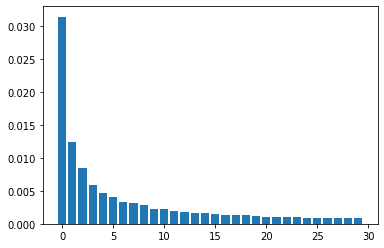

In [9]:
# Explained variance
plt.bar(list(range(0, 30)), pca.explained_variance_ratio_[:30])

### Experiments overlaop

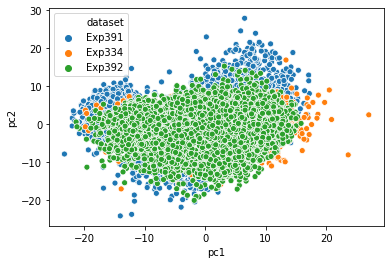

In [10]:
plot_tb = pd.DataFrame({'pc1':expr_scaled_arr_pca[:,0], 'pc2':expr_scaled_arr_pca[:,1], 
                        'pc3':expr_scaled_arr_pca[:,2], 'dataset':meta_tb['dataset']})
sns.scatterplot(data=plot_tb, x='pc1', y='pc2', hue='dataset')

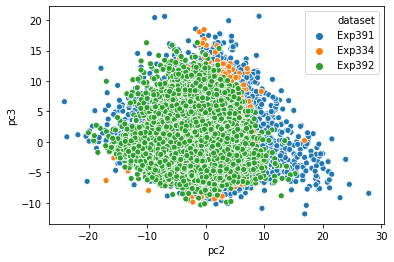

In [11]:
sns.scatterplot(data=plot_tb, x='pc2', y='pc3', hue='dataset')

-----

## 2. Run Harmony

In [12]:
time.pre = time.time()
ho = hm.run_harmony(expr_scaled_arr_pca, meta_tb, ['dataset'])
time.post = time.time()

runtime = time.post - time.pre
print("Total Runtime in seconds: %s"%runtime)

2020-04-29 13:30:17,867 - harmonypy - INFO - Iteration 1 of 10
2020-04-29 13:30:23,047 - harmonypy - INFO - Iteration 2 of 10
2020-04-29 13:30:28,108 - harmonypy - INFO - Iteration 3 of 10
2020-04-29 13:30:33,375 - harmonypy - INFO - Iteration 4 of 10
2020-04-29 13:30:38,321 - harmonypy - INFO - Iteration 5 of 10
2020-04-29 13:30:42,949 - harmonypy - INFO - Iteration 6 of 10
2020-04-29 13:30:47,593 - harmonypy - INFO - Converged after 6 iterations


Total Runtime in seconds: 37.61580467224121


In [13]:
###----- Save output
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
res.to_csv("adj.tsv.gz", sep = "\t", index = False)

### Experiments overlap

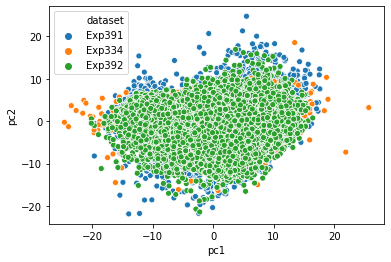

In [14]:
plot_tb = pd.DataFrame({'pc1':ho.Z_corr[0], 'pc2':ho.Z_corr[1], 
                        'pc3':ho.Z_corr[2], 'dataset':meta_tb['dataset']})
sns.scatterplot(data=plot_tb, x='pc1', y='pc2', hue='dataset')

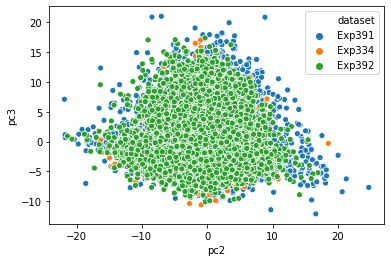

In [15]:
sns.scatterplot(data=plot_tb, x='pc2', y='pc3', hue='dataset')

-----

## 2. Run UMAP with Hamony adjusted PCs

In [16]:
reducer = umap.UMAP(n_neighbors = 250, random_state=123)
umap_embedding = reducer.fit_transform(ho.Z_corr.transpose())

/home/pipkin/anaconda3/envs/scanpy/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/pipkin/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/pipkin/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../..

### Plot UMAP projection

In [72]:
plot_tb = pd.DataFrame(umap_embedding)
plot_tb['dataset'] = meta_tb['dataset']
plot_tb['cell_id'] = meta_tb['cell_id']
NAV_names = ['NP14B', 'NAV','P14NAV']
NAV_ACT = ['NAV' if x in NAV_names else 'ACT' for x in meta_tb['cell_type']]
plot_tb['NAV_ACT'] = NAV_ACT

plot_tb['ds_id'] = ["_".join([x, y]) for index, (x,y) in enumerate(zip(plot_tb['dataset'], plot_tb['cell_id']))]
usedCells_meta_tb_toAdd = usedCells_meta_tb[['ds_id', 'louvain']]

plot_tb = pd.merge(plot_tb, usedCells_meta_tb_toAdd, on='ds_id', how='left')

*Convert labels*

In [73]:
exp391_label_tb = pd.read_csv("Exp391_newLabels.csv")
exp334_label_tb = pd.read_csv("Exp334_newLabels.csv")
exp392_label_tb = pd.read_csv("Exp392_newLabels.csv")
label_dict = {"Exp391": [list(exp391_label_tb['old_label']), list(exp391_label_tb['new_label'])],
             "Exp334": [list(exp334_label_tb['old_label']), list(exp334_label_tb['new_label'])],
             "Exp392": [list(exp392_label_tb['old_label']), list(exp392_label_tb['new_label'])]}

plot_tb_old_label = ["%s_%s"%(str(x), str(y)) for index, (x,y) in enumerate(zip(list(plot_tb['dataset']), plot_tb['louvain']))]
plot_tb_new_label = []
for i in plot_tb_old_label:
    i_exp = i.split("_")[0]
    i_new = i.split("_")[1]
    for index, (x, y) in enumerate(zip(label_dict[i_exp][0], label_dict[i_exp][1])):
        i_new = i_new.replace(x, y)
    plot_tb_new_label.append(i_new)
plot_tb['louvain_oldLabel'] = list(plot_tb['louvain'])
plot_tb['louvain'] = plot_tb_new_label

*Before / after outlier removal*

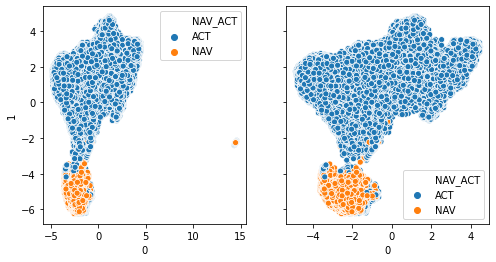

In [74]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
sns.scatterplot(data=plot_tb, x=0, y=1, hue='NAV_ACT', ax=ax1)

outlier_scores = sklearn.neighbors.LocalOutlierFactor(n_neighbors = 200, contamination=0.01).fit_predict(umap_embedding)
plot_tb['outlier_scores'] = outlier_scores
plot_tb_rmOutliers = plot_tb[plot_tb['outlier_scores'] != -1]
sns.scatterplot(data=plot_tb_rmOutliers, x=0, y=1, hue='NAV_ACT', ax=ax2)

*NAV v.s. ACT seperate*

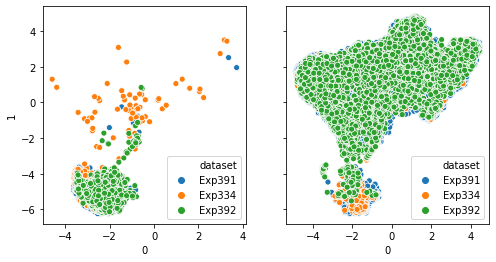

In [75]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
sns.scatterplot(data=plot_tb_rmOutliers[plot_tb_rmOutliers['NAV_ACT']=='NAV'], x=0, y=1, hue='dataset', ax=ax1)
sns.scatterplot(data=plot_tb_rmOutliers[plot_tb_rmOutliers['NAV_ACT']=='ACT'], x=0, y=1, hue='dataset', ax=ax2)

*All experiments*

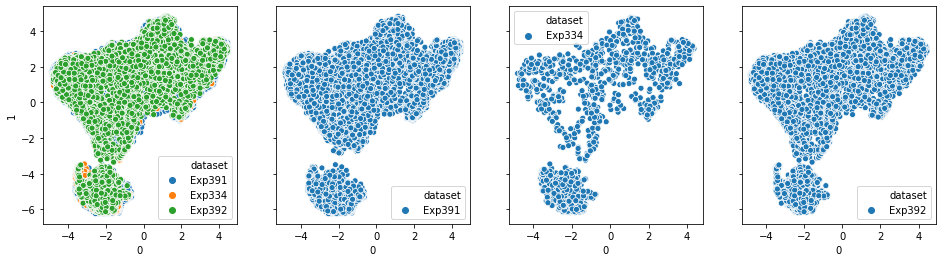

In [76]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, figsize=(16, 4))
sns.scatterplot(data=plot_tb_rmOutliers, x=0, y=1, hue='dataset', ax=ax1)
sns.scatterplot(data=plot_tb_rmOutliers[plot_tb_rmOutliers['dataset']=='Exp391'], x=0, y=1, hue='dataset', ax=ax2)
sns.scatterplot(data=plot_tb_rmOutliers[plot_tb_rmOutliers['dataset']=='Exp334'], x=0, y=1, hue='dataset', ax=ax3)
sns.scatterplot(data=plot_tb_rmOutliers[plot_tb_rmOutliers['dataset']=='Exp392'], x=0, y=1, hue='dataset', ax=ax4)

*Louvain*

In [93]:
plot_tb_391_louvain = plot_tb_rmOutliers[plot_tb_rmOutliers['dataset']=='Exp391']
plot_tb_334_louvain = plot_tb_rmOutliers[plot_tb_rmOutliers['dataset']=='Exp334']
plot_tb_392_louvain = plot_tb_rmOutliers[plot_tb_rmOutliers['dataset']=='Exp392']

plot_tb_391_louvain = plot_tb_391_louvain[plot_tb_391_louvain['louvain'] != 'nan']
plot_tb_334_louvain = plot_tb_334_louvain[plot_tb_334_louvain['louvain'] != 'nan']
plot_tb_392_louvain = plot_tb_392_louvain[plot_tb_392_louvain['louvain'] != 'nan']

# Set label order
order_391 = list(set( plot_tb_391_louvain['louvain']))
order_334 = list(set( plot_tb_334_louvain['louvain']))
order_392 = list(set( plot_tb_392_louvain['louvain']))
order_391.sort()
order_334.sort()
order_392.sort()

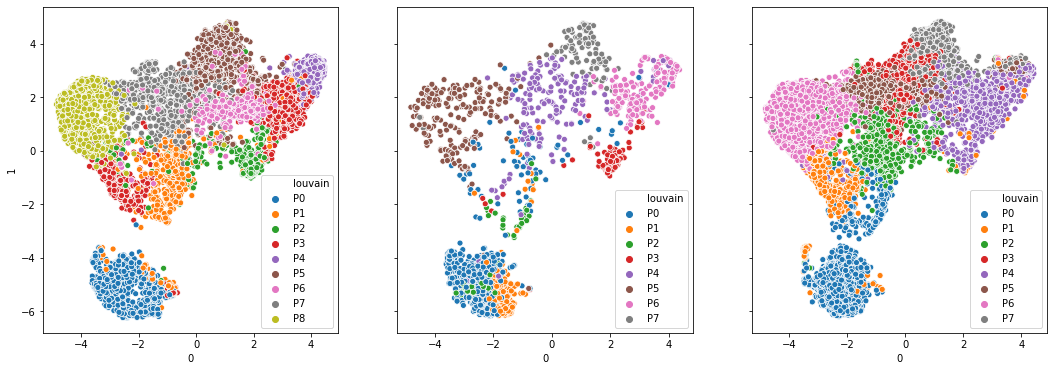

In [94]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(18, 6))
sns.scatterplot(data=plot_tb_391_louvain, x=0, y=1, hue='louvain', hue_order = order_391, ax=ax1)
sns.scatterplot(data=plot_tb_334_louvain, x=0, y=1, hue='louvain', hue_order = order_334, ax=ax2)
sns.scatterplot(data=plot_tb_392_louvain, x=0, y=1, hue='louvain', hue_order = order_392, ax=ax3)

In [100]:
# Calculate sihouette score between clusters in different experiments
exps_dict = {'Exp391': plot_tb_391_louvain, 'Exp334': plot_tb_334_louvain, 'Exp392': plot_tb_392_louvain}
exps_label_dict = {}
for exp in ['Exp391', 'Exp334', 'Exp392']:
    exp_tb = exps_dict[exp]
    exp_labels = list(set(list(exp_tb['louvain'])))
    exp_labels = [x for x in exp_labels if str(x) != 'nan']
    exps_label_dict[exp] = len(exp_labels)

for i, j in itertools.combinations(['Exp391', 'Exp334', 'Exp392'], 2):
    i_tb = exps_dict[i]
    j_tb = exps_dict[j]

    i_labels = ["P%s"%str(x) for x in range(0, exps_label_dict[i])]
    j_labels = ["P%s"%str(x) for x in range(0, exps_label_dict[j])]
    i_j_s_tb = pd.DataFrame({"Cluster": ["%s_%s"%(i, x) for x in i_labels]})

    for j_label in j_labels:
        j_col = []
        for i_label in i_labels:
            j_label_name = "%s_%s"%(j, j_label)
            i_label_name = "%s_%s"%(i, i_label)
            i_label_tb = i_tb[i_tb['louvain']==i_label][[0,1]]
            j_label_tb = j_tb[j_tb['louvain']==j_label][[0,1]]
            i_j_tb = pd.concat([i_label_tb, j_label_tb])
            i_j = [i_label_name for x in range(0, len(i_label_tb))] + [j_label_name for x in range(0, len(j_label_tb))]
            i_j_s = sklearn.metrics.silhouette_score(i_j_tb.to_numpy(), i_j)
            j_col.append(i_j_s)
        i_j_s_tb[j_label_name] = j_col

    i_j_s_tb_name = "%s_%s_silhouette.csv"%(i, j)
    i_j_s_tb.to_csv(i_j_s_tb_name, index=False)

[Text(995.1529411764707, 0.5, 'Exp391'), Text(0.5, 24.0, 'Exp392')]

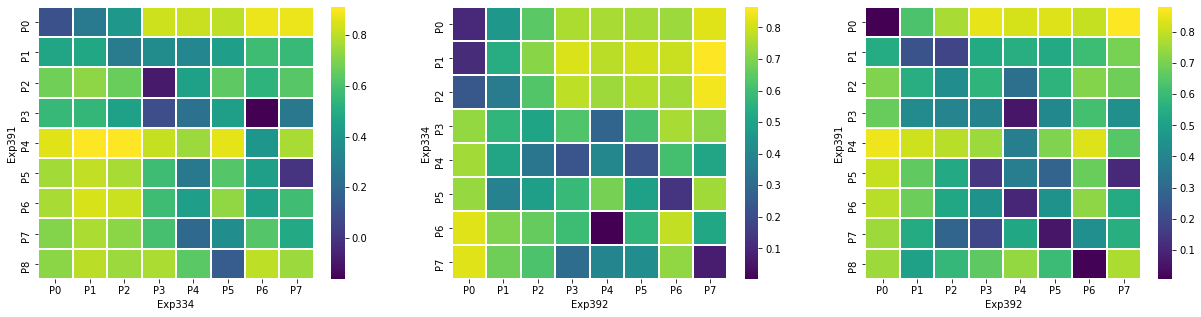

In [105]:
# Heatmap
S391_334 = "Exp391_Exp334_silhouette.csv"
S334_392 = "Exp334_Exp392_silhouette.csv"
S391_392 = "Exp391_Exp392_silhouette.csv"

S391_334_tb = pd.read_csv(S391_334)
S334_392_tb = pd.read_csv(S334_392)
S391_392_tb = pd.read_csv(S391_392)

S391_334_tb['Cluster'] = [x.split("_")[-1] for x in S391_334_tb['Cluster']]
S334_392_tb['Cluster'] = [x.split("_")[-1] for x in S334_392_tb['Cluster']]
S391_392_tb['Cluster'] = [x.split("_")[-1] for x in S391_392_tb['Cluster']]

S391_334_tb.columns = [x.split("_")[-1] for x in list(S391_334_tb.columns)]
S334_392_tb.columns = [x.split("_")[-1] for x in list(S334_392_tb.columns)]
S391_392_tb.columns = [x.split("_")[-1] for x in list(S334_392_tb.columns)]

S391_334_tb = S391_334_tb.set_index("Cluster")
S334_392_tb = S334_392_tb.set_index("Cluster")
S391_392_tb = S391_392_tb.set_index("Cluster")

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(21, 5))
sns.heatmap(S391_334_tb, cmap="viridis", ax=ax1, linewidths=1)
ax1.set(xlabel='Exp334', ylabel='Exp391')
sns.heatmap(S334_392_tb, cmap="viridis", ax=ax2, linewidths=1)
ax2.set(xlabel='Exp392', ylabel='Exp334')
sns.heatmap(S391_392_tb, cmap="viridis", ax=ax3, linewidths=1)
ax3.set(xlabel='Exp392', ylabel='Exp391')

-----

## 2. Run UMAP with original PCs

In [56]:
reducer = umap.UMAP(n_neighbors = 250, random_state=123)
umap_embedding_originalPCs = reducer.fit_transform(expr_scaled_arr_pca)

/home/pipkin/anaconda3/envs/scanpy/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/pipkin/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/pipkin/anaconda3/envs/scanpy/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../

### Plot UMAP projection

In [62]:
plot_tb_op = pd.DataFrame(umap_embedding_originalPCs)
plot_tb_op['dataset'] = meta_tb['dataset']
NAV_names = ['NP14B', 'NAV','P14NAV']
NAV_ACT = ['NAV' if x in NAV_names else 'ACT' for x in meta_tb['cell_type']]
plot_tb_op['NAV_ACT'] = NAV_ACT
plot_tb_op['dataset'] = meta_tb['dataset']

*Before / after outlier removal*

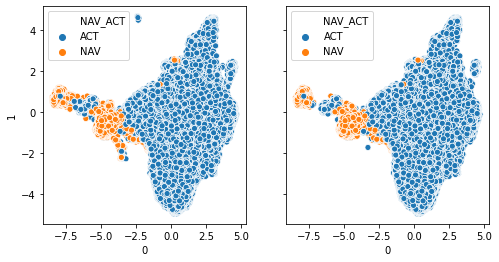

In [63]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
sns.scatterplot(data=plot_tb_op, x=0, y=1, hue='NAV_ACT', ax=ax1)

outlier_scores = sklearn.neighbors.LocalOutlierFactor(n_neighbors = 200, contamination=0.01).fit_predict(umap_embedding_originalPCs)
plot_tb_op['outlier_scores'] = outlier_scores
plot_tb_op_rmOutliers = plot_tb_op[plot_tb_op['outlier_scores'] != -1]
sns.scatterplot(data=plot_tb_op_rmOutliers, x=0, y=1, hue='NAV_ACT', ax=ax2)

*NAV v.s. ACT seperate*

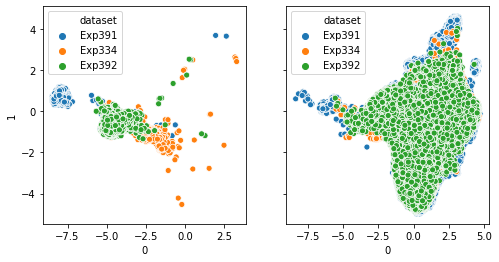

In [65]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
sns.scatterplot(data=plot_tb_op_rmOutliers[plot_tb_op_rmOutliers['NAV_ACT']=='NAV'], x=0, y=1, hue='dataset', ax=ax1)
sns.scatterplot(data=plot_tb_op_rmOutliers[plot_tb_op_rmOutliers['NAV_ACT']=='ACT'], x=0, y=1, hue='dataset', ax=ax2)